# Evaluating the Finetuned Model

### Basic Setup

In [1]:
import torch 
import torchvision
import torch.nn as nn 
import torch.nn.init as init
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import os

import torch.optim as optim
import time
import torch.nn.functional as F

import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

%matplotlib inline

In [2]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch


### Data and Model

In [3]:
train = pickle.load(open('okcupid_train.pkl', 'rb'))
val = pickle.load(open('okcupid_val.pkl', 'rb'))
test = pickle.load(open('okcupid_test.pkl', 'rb'))

In [5]:
class GPTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, batch_size):
        #tokenizers usually do the tokenization and numericalization in one step, use encode to get word->index and  
        # decode to get index->word
        self.tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.dataset = dataset
        self.batch_size = batch_size
        
        self.batches = []
        
        for i in range(int(len(self.dataset) / batch_size)):
            batch = self.dataset[i * self.batch_size : (i + 1) * self.batch_size]
            self.batches += [self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt")]
            
    def __getitem__(self, index):
        return self.batches[index]

    def __len__(self):
        return len(self.batches)

In [6]:
train_dataset = pickle.load(open('train_dataset.p', 'rb'))
val_dataset = pickle.load(open('val_dataset.p', 'rb'))
test_dataset = pickle.load(open('test_dataset.p', 'rb'))

In [25]:
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
#model = model.cuda()
model.resize_token_embeddings(len(train_dataset.tokenizer))
model.load_state_dict(torch.load('lr-bs3-5e5.pt'))


<All keys matched successfully>

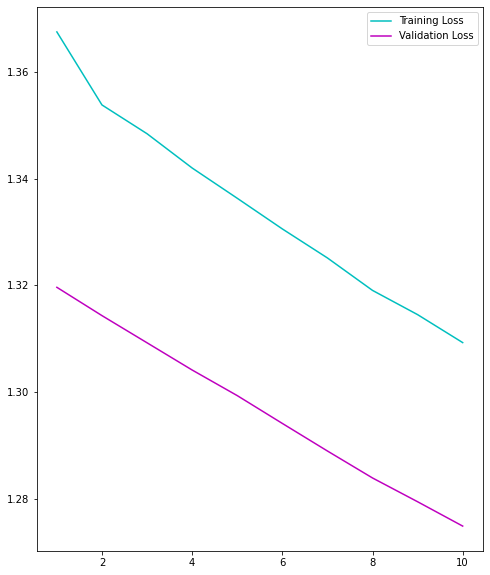

In [21]:
import math
train_loss = [3.925748, 3.872345,3.851492, 3.826822, 3.805162,3.783345, 3.762812, 3.739974, 3.723015, 3.703537 ]
valid_loss = [3.742136,3.722326,  3.703400,3.684544, 3.666903, 3.647822,  3.629009,3.610696, 3.594632, 3.578252 ]
epoch =[i for i in range(1,11)]

plt.figure(figsize =(8,10))
plt.plot( epoch,[math.log(i) for i in train_loss], color='c')
plt.plot( epoch,[math.log(i) for i in valid_loss],color='m')
plt.legend(["Training Loss", "Validation Loss"], loc= 'upper right')
plt.show()

In [139]:
def generate(model, tokenizer, prompt, entry_count=1, entry_length=30, top_p =0.4, temperature = 1.2,):
    model.eval()
    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in range(entry_count):

            entry_finished = False
            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("[PAD]"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text.split("=> ")[1])
                    #generated_list.append(output_text)
                    break
            
            if not entry_finished:
                output_list = list(generated.squeeze().numpy())
                output_text = f"{tokenizer.decode(output_list)}" 
                generated_list.append(output_text.split("=> ")[1])
                #generated_list.append(output_text)
    return generated_list

In [151]:
# def text_generation(test_data, gptdata, model):
#     #testdata has to be a dataframe, use test and not test_dataset
#     generated_desc = []
#     for i in range(len(test_data)):
#         x = generate(model.to('cpu'), gptdata.tokenizer, test_data[i], entry_count=1)
#         generated_desc.append(x[0])
#     return generated_desc

def text_generation(test_data, gptdata, model, startidx, endidx):
    #testdata has to be a dataframe, use test and not test_dataset
    generated_desc = []
    for i in range(startidx, endidx):
        x = generate(model.to('cpu'), gptdata.tokenizer, test_data[i], entry_count=1)
        generated_desc.append(x[0])
    return generated_desc


In [152]:
#Run the functions to generate the descriptions, append them to a list
import pandas as pd
#generated10 = generated
generated20 = text_generation(test, test_dataset, model, 10, 20)


In [153]:
generated30 = text_generation(test, test_dataset, model, 20, 30)


In [154]:

generated40 = text_generation(test, test_dataset, model, 30, 40)


In [155]:

generated50 = text_generation(test, test_dataset, model, 40, 50)

In [158]:
generated60 = text_generation(test, test_dataset, model,  50, 60)
generated70 = text_generation(test, test_dataset, model,   60, 70)
generated80 = text_generation(test, test_dataset, model,   70, 80)
generated90 = text_generation(test, test_dataset, model,   80, 90)
generated100 = text_generation(test, test_dataset, model,   90,100)

In [134]:
#generate reference list
ref = []
for i in test:
    i = i.split("=> ")[1]
    ref.append(i)


### ROUGE

In [62]:
#https://pypi.org/project/rouge/
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [164]:
generated_total_50 = generated10+ generated20 + generated30 + generated40 + generated50
generated_total_100 = generated_total_50 + generated60+ generated70 + generated80 + generated90 + generated100
len(generated_total_100)

100

In [157]:
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(generated_total_50, ref[:50], avg=True)
print("ROUGE on 50 test set items")
scores

ROUGE on 50 test set items


{'rouge-1': {'r': 0.9835673401792071,
  'p': 0.8206438237678235,
  'f': 0.8854573893096525},
 'rouge-2': {'r': 0.9808489445281038,
  'p': 0.7861728079781679,
  'f': 0.8615785724631373},
 'rouge-l': {'r': 0.9835673401792071,
  'p': 0.8206438237678235,
  'f': 0.8854573893096525}}

In [165]:
scores = rouge.get_scores(generated_total_100, ref[:100], avg=True)
print("ROUGE on 100 test set items")
scores

ROUGE on 100 test set items


{'rouge-1': {'r': 0.9849490223335693,
  'p': 0.8278840197441778,
  'f': 0.8897828519247429},
 'rouge-2': {'r': 0.981706066200595,
  'p': 0.7941089657137553,
  'f': 0.8664325899073703},
 'rouge-l': {'r': 0.9849490223335693,
  'p': 0.8278840197441778,
  'f': 0.8897828519247429}}